# Grab Repository data      

In [1]:
from dotenv import load_dotenv
from helper.general import split_by_date, generate_value_in_buckets, truncate_to_same_length, validate_path, get_repository_paths
from helper.significance import check_normality_of_buckets, use_normality_results_for_significance_independent
import logging
import pandas as pd
import ast
import os
import matplotlib.pyplot as plt

load_dotenv(override=True)

True

In [2]:
REPO_PATHS = os.getenv('STORAGE_DIRECTORIES')
repository_directories = ast.literal_eval(REPO_PATHS) if REPO_PATHS else []
INTRO_DATE = os.getenv('INTRO_DATE')
START_DATE = os.getenv('START_DATE')
END_DATE = os.getenv('END_DATE')
BUCKET_SIZE = int(os.getenv('BUCKET_SIZE'))
RESULTS_DIRECTORY = os.getenv("RESULTS_DIRECTORY")
storage_path = f'{RESULTS_DIRECTORY}/metric_calculation_{BUCKET_SIZE}/time_to_merge_into_main_per_{BUCKET_SIZE}_days.csv'

# Get only first-level subfolders in the repository directories
repositories = get_repository_paths(repository_directories)

print(repositories)

['/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P3', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P9', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P2', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P8', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P1', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/k1bu0cscd4', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/5x4imrvk5b', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P7', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P5', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P14', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P6', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/non-participants', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/bznd2hh7ii', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person

In [3]:
if INTRO_DATE == "":
    import json
    mapping_file = f"{repository_directories[0]}/mapping.json"
    # Check if the file exists
    if not os.path.exists(mapping_file):
        print(f"File not found: {mapping_file}. ")
    with open(mapping_file, 'r') as f:
        mapping = json.load(f)
    print(f"Using INTRO_DATE from mapping file: {INTRO_DATE}")

START_DATE = None
END_DATE = None


Using INTRO_DATE from mapping file: 


# Generate Branch Metrics per Repository

## Time to merge Commits

In [4]:
def parse_duration(duration_str):
    try:
        days, hours, minutes, seconds = map(int, duration_str.split(":"))
        return pd.Timedelta(days=days, hours=hours, minutes=minutes, seconds=seconds)
    except:
        return pd.NaT  # handle invalid formats


In [5]:
def was_before_and_distance(date1, date2):
    date1 = pd.to_datetime(date1).tz_localize(None)  # Remove timezone information
    date2 = pd.to_datetime(date2).tz_localize(None)  # Remove timezone information
    intro_date = pd.to_datetime(INTRO_DATE).tz_localize(None)  # Remove timezone information
    
    time_difference = abs((date2 - date1).total_seconds())  # Calculate time difference in seconds
    
    if date1 < intro_date and date2 < intro_date:
        return True, time_difference
    elif date1 > intro_date and date2 > intro_date:
        return False, time_difference
    else:
        if intro_date - date1 < date2 - intro_date:
            return False, time_difference
        else:
            return True, time_difference
repos = []
commit_merges = {}
for repository in repositories:
    if INTRO_DATE == "":
        person = repository.split('/')[-1]
        INTRO_DATE = mapping[person]['INTRO_DATE']
        START_DATE = mapping[person]['START_DATE']
        END_DATE = mapping[person]['END_DATE']
    repos.append(repository)
    branch_file = f"{repository}/branches.csv"
    pr_file = f"{repository}/pull_requests.csv"
    commit_file = f"{repository}/commits.csv"
    
    if not validate_path(branch_file) or not validate_path(pr_file) or not validate_path(commit_file):
        continue
    
    branches = pd.read_csv(branch_file)
    commits = pd.read_csv(commit_file)
    prs = pd.read_csv(pr_file)  # Corrected to read the pull requests file
    
    commit_pr_merge_moments = []
    for _, branch_row in branches.iterrows():
        if not isinstance(branch_row['commits'], str) or branch_row['commits'] is None:
            continue
        
        # Convert the string representation of the list to an actual list
        commits_list = ast.literal_eval(branch_row['commits'])
        branch_commits = commits[commits['sha'].isin(commits_list)]
        branch_name = branch_row['branch_name']
        
        branch_commits = branch_commits.sort_values('date')
        first_commit_since_pr = None
        last_pr = None
        
        for _, commit_row in branch_commits.iterrows():
            commit = commit_row['sha']
            
            if first_commit_since_pr is None:
                first_commit_since_pr = commit
            
            if commit in prs['sha'].values:
                last_pr = commit
            
            if first_commit_since_pr is not None and last_pr is not None:
                commit_date = branch_commits.loc[branch_commits['sha'] == first_commit_since_pr, 'date'].values[0]
                pr_date = branch_commits.loc[branch_commits['sha'] == last_pr, 'date'].values[0]
                
                before_bucket, time_distance = was_before_and_distance(commit_date, pr_date)
                commit_pr_merge_moments.append({
                    'commit_sha': first_commit_since_pr,
                    'pr_sha': last_pr,
                    'commit_date': commit_date,
                    'pr_date': pr_date,
                    'time_distance': time_distance,
                    'before_bucket': before_bucket,
                    'branch': branch_name
                })
                
                first_commit_since_pr = None
                last_pr = None
    
    commit_merges[repository] = commit_pr_merge_moments

print(len(commit_merges))


File not found or empty: /Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/k1bu0cscd4/branches.csv. Skipping repository.
File not found or empty: /Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/non-participants/branches.csv. Skipping repository.
17


In [6]:
results = []
for repository in repos:
    if repository not in commit_merges:
        continue
    repo_df = pd.DataFrame(commit_merges[repository])
    if repo_df.empty:
        # print(f"No data for repository {repository}. Adding NaN row...")
        # results.append({'repository': repository, 'time_distance': float('nan')})

        continue
    
    # Convert time_distance to days
    repo_df['time_distance'] = repo_df['time_distance'] / 86400.0
    
    repo_df = truncate_to_same_length(repo_df, INTRO_DATE, 'pr_date', 'defined', START_DATE, END_DATE)
    
    pre_release = repo_df[repo_df['before_bucket'] == True]
    post_release = repo_df[repo_df['before_bucket'] == False]

    print("Pre-release date range:", pre_release['pr_date'].min(), pre_release['pr_date'].max())
    print("After-release date range:", post_release['pr_date'].min(), post_release['pr_date'].max())

    pre_release_buckets = generate_value_in_buckets(pre_release, 'pr_date', 'time_distance', 'mean', BUCKET_SIZE, 'pre-', create_empty_buckets=False)
    post_release_buckets = generate_value_in_buckets(post_release, 'pr_date', 'time_distance', 'mean', BUCKET_SIZE, 'post-', create_empty_buckets=False)

    release_buckets = pd.concat([pre_release_buckets, post_release_buckets], ignore_index=True)

    repo_name = repository.split('/')[-1]
    
    result_row = {'repository': repo_name}
    result_row.update(release_buckets.set_index('bucket')['time_distance'].to_dict())  # Use 'count' instead of 'value'
    
    results.append(result_row)
results
# Create the DataFrame
result_df = pd.DataFrame(results)
result_df

Pre-release date range: 2024-06-13 09:03:10+00:00 2024-10-02 09:50:30+00:00
After-release date range: 2024-10-29 09:02:37+00:00 2025-02-06 15:53:28+00:00
Pre-release date range: NaT NaT
After-release date range: NaT NaT
Pre-release date range: 2024-06-18 06:53:01+00:00 2024-09-30 12:09:09+00:00
After-release date range: 2024-11-13 07:28:26+00:00 2025-02-13 11:25:45+00:00
Pre-release date range: NaT NaT
After-release date range: NaT NaT
Pre-release date range: 2024-06-18 14:29:02+00:00 2024-10-11 15:09:17+00:00
After-release date range: 2024-10-16 13:57:12+00:00 2025-01-13 15:55:43+00:00
Pre-release date range: 2024-06-18 10:26:25+00:00 2024-09-20 07:47:46+00:00
After-release date range: NaT NaT
Pre-release date range: 2024-06-13 12:13:51+00:00 2024-10-24 12:20:45+00:00
After-release date range: 2024-10-17 13:07:30+00:00 2025-02-10 13:25:04+00:00
Pre-release date range: NaT NaT
After-release date range: 2025-02-05 06:59:45+00:00 2025-02-05 06:59:45+00:00
Pre-release date range: 2024-06-

/var/folders/19/fmw641dj3bnfy5qbgqrzmf100000gn/T/ipykernel_66897/91699919.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  release_buckets = pd.concat([pre_release_buckets, post_release_buckets], ignore_index=True)
/var/folders/19/fmw641dj3bnfy5qbgqrzmf100000gn/T/ipykernel_66897/91699919.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  release_buckets = pd.concat([pre_release_buckets, post_release_buckets], ignore_index=True)
/var/folders/19/fmw641dj3bnfy5qbgqrzmf100000gn/T/ipykernel_668

,repository,pre-0,pre-1,pre-2,pre-3,pre-4,pre-5,pre-6,pre-7,post-0,post-1,post-2,post-3,post-4,post-5,post-6,post-7,pre-8,pre-9,post-8
0,P9,47.982890,16.131840,6.946250,24.816204,3.053229,1.986557,NaN,0.026481,22.003125,15.168461,NaN,0.077546,NaN,20.789595,NaN,2.099306,NaN,NaN,NaN
1,P2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,P8,2.582860,0.669842,0.508329,6.185332,2.077619,0.224890,10.529051,2.069144,42.717882,21.726264,NaN,NaN,53.856227,1.820731,12.797368,NaN,NaN,NaN,NaN
3,P1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5x4imrvk5b,12.016377,NaN,NaN,NaN,NaN,NaN,3.544601,25.594946,2.917878,NaN,23.668325,0.010347,NaN,51.989190,24.968657,NaN,0.490767,NaN,NaN
5,P7,139.686092,8.128096,18.661414,0.000000,28.928067,NaN,0.028877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,P14,37.680480,8.573689,1.374356,23.940359,9.393189,7.371420,3.465694,4.722770,0.376795,3.907656,NaN,NaN,NaN,78.422182,69.453741,4.957381,NaN,38.074375,173.020509
7,P6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.930752,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,bznd2hh7ii,0.009178,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,xd8qar3azx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
pre_release_buckets

,bucket,time_distance,start_date,end_date
0,pre-0,10.043715,2024-06-10 13:04:31+00:00,2024-06-24 13:04:31+00:00
1,pre-1,NaN,NaT,NaT
2,pre-2,32.831204,2024-07-08 13:04:31+00:00,2024-07-22 13:04:31+00:00
3,pre-3,4.093125,2024-07-22 13:04:31+00:00,2024-08-05 13:04:31+00:00
4,pre-4,13.998183,2024-08-05 13:04:31+00:00,2024-08-19 13:04:31+00:00
5,pre-5,NaN,NaT,NaT
6,pre-6,35.997488,2024-09-02 13:04:31+00:00,2024-09-16 13:04:31+00:00
7,pre-7,3.965313,2024-09-16 13:04:31+00:00,2024-09-30 13:04:31+00:00
8,pre-8,NaN,NaT,NaT
9,pre-9,28.124630,2024-10-14 13:04:31+00:00,2024-10-28 13:04:31+00:00


In [8]:
# Ensure the columns are in the correct order
def sort_buckets(df, prefix_one, prefix_two):
    order = ['repository']
    
    for prefix in [prefix_one, prefix_two]:
        counter = 0
        contained = True
        
        while contained:
            order.append(f'{prefix}{counter}')
            
            counter += 1
            if not f'{prefix}{counter}' in df:
                contained = False
        
    return order

columns_order = sort_buckets(result_df, 'pre-', 'post-')
result_df = result_df[columns_order]

In [9]:
result_df

,repository,pre-0,pre-1,pre-2,pre-3,pre-4,pre-5,pre-6,pre-7,pre-8,pre-9,post-0,post-1,post-2,post-3,post-4,post-5,post-6,post-7,post-8
0,P9,47.982890,16.131840,6.946250,24.816204,3.053229,1.986557,NaN,0.026481,NaN,NaN,22.003125,15.168461,NaN,0.077546,NaN,20.789595,NaN,2.099306,NaN
1,P2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,P8,2.582860,0.669842,0.508329,6.185332,2.077619,0.224890,10.529051,2.069144,NaN,NaN,42.717882,21.726264,NaN,NaN,53.856227,1.820731,12.797368,NaN,NaN
3,P1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5x4imrvk5b,12.016377,NaN,NaN,NaN,NaN,NaN,3.544601,25.594946,0.490767,NaN,2.917878,NaN,23.668325,0.010347,NaN,51.989190,24.968657,NaN,NaN
5,P7,139.686092,8.128096,18.661414,0.000000,28.928067,NaN,0.028877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,P14,37.680480,8.573689,1.374356,23.940359,9.393189,7.371420,3.465694,4.722770,NaN,38.074375,0.376795,3.907656,NaN,NaN,NaN,78.422182,69.453741,4.957381,173.020509
7,P6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.930752,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,bznd2hh7ii,0.009178,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,xd8qar3azx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# for col in result_df.columns[1:]:  # Skip 'repository'
#     result_df[col] = pd.to_timedelta(result_df[col], errors='coerce')


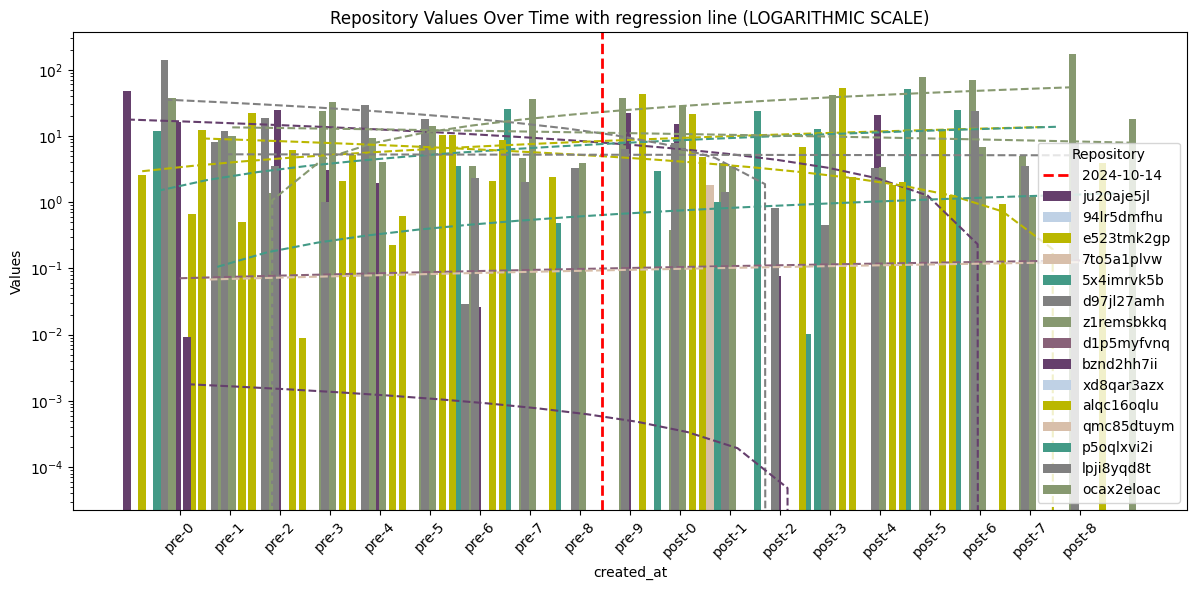

In [11]:
import numpy as np
from scipy.stats import linregress

# Plotting the visualization as a grouped bar chart
plt.figure(figsize=(12, 6))

# Extract the date columns (x-axis labels)
date_columns = [col for col in result_df.columns if col != 'repository']
colors = ["#653F6C", "#BFD1E5", "#BAB700", "#D8BFAA", "#439A86", "#808080", "#879970", "#896279"]
x = np.arange(len(date_columns))  # Numeric positions for the x-axis

# Bar width for grouped bars
bar_width = 0.15

# Loop through each repository and plot its bars
for i, repo in enumerate(result_df['repository']):
    # Extract data for the current repository
    values = result_df[result_df['repository'] == repo].iloc[0, 1:].astype(float).fillna(0)
    # Adjust the x positions for this repository's bars
    plt.bar(x + i * bar_width, values.values, bar_width, label=repo, color=colors[i % len(colors)])
    
    # Add a regression line for the repository
    # Perform linear regression
    slope, intercept, _, _, _ = linregress(x, values.values)
    regression_line = slope * x + intercept
    plt.plot(x + i * bar_width, regression_line, color=colors[i % len(colors)], linestyle='--', label=f"_nolegend_")

# Dynamically find the largest 'pre-x' and 'post-0'
x_ticks = result_df.columns[1:]  # Assuming these are the x-axis labels
pre_columns = [col for col in x_ticks if col.startswith('pre-')]
post_columns = [col for col in x_ticks if col.startswith('post-')]

if pre_columns and post_columns:
    largest_pre = max(pre_columns, key=lambda x: int(x.split('-')[1]))  # Find the largest 'pre-x'
    post_0 = 'post-0' if 'post-0' in post_columns else None  # Ensure 'post-0' exists

    if largest_pre and post_0:
        pre_index = list(x_ticks).index(largest_pre)
        post_0_index = list(x_ticks).index(post_0)
        midpoint = (pre_index + post_0_index) / 2
        plt.axvline(x=midpoint, color='red', linestyle='--', linewidth=2, label=INTRO_DATE)

# Set x-axis ticks and labels
plt.xticks(x + (len(result_df['repository']) - 1) * bar_width / 2, date_columns, rotation=45)

# Add labels and title
plt.title('Repository Values Over Time with regression line (LOGARITHMIC SCALE)')
plt.xlabel('created_at')
plt.ylabel('Values')
plt.legend(title='Repository')
plt.tight_layout()
plt.yscale('log')
plt.show()

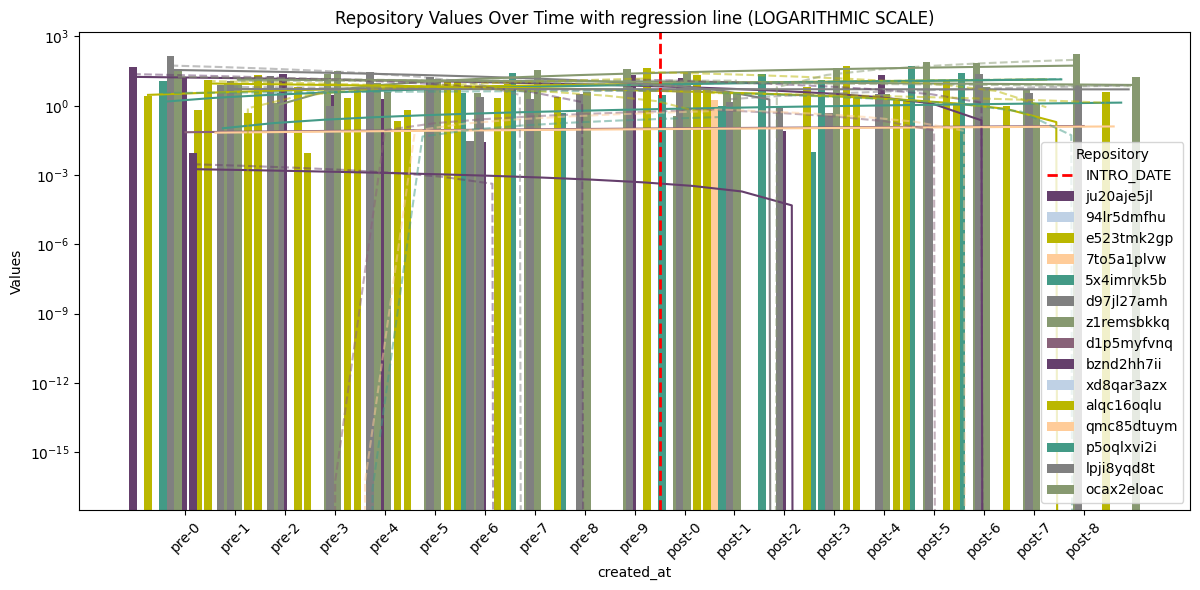

In [12]:
import numpy as np
from scipy.stats import linregress

tangent_data = []

# Plotting the visualization as a grouped bar chart
plt.figure(figsize=(12, 6))

# Extract the date columns (x-axis labels)
date_columns = [col for col in result_df.columns if col != 'repository']
colors = ["#FF4500", "#FFA500", "#FF8C00", "#FFD700", "#FF6347", "#FF7F50", "#FFB347", "#FFCC99"]
colors = ["#653F6C", "#BFD1E5", "#BAB700", "#FFCC99", "#439A86", "#808080", "#879970", "#896279"]
x = np.arange(len(date_columns))  # Numeric positions for the x-axis

# Bar width for grouped bars
bar_width = 0.15

# Loop through each repository and plot its bars
for i, repo in enumerate(result_df['repository']):
    # Extract data for the current repository
    values = result_df[result_df['repository'] == repo].iloc[0, 1:].astype(float).fillna(0)
    # Adjust the x positions for this repository's bars
    plt.bar(x + i * bar_width, values.values, bar_width, label=repo, color=colors[i % len(colors)])
    
    # Add a regression line for the repository
    # Perform linear regression
    m, b, _, _, _ = linregress(x, values.values)
    regression_line = m * x + b
    plt.plot(x + i * bar_width, regression_line, color=colors[i % len(colors)], linestyle='-', label=f"_nolegend_")

# Dynamically find the largest 'pre-x' and 'post-0'
x_ticks = result_df.columns[1:]  # Assuming these are the x-axis labels
pre_columns = [col for col in x_ticks if col.startswith('pre-')]
post_columns = [col for col in x_ticks if col.startswith('post-')]

if pre_columns and post_columns:
    largest_pre = max(pre_columns, key=lambda x: int(x.split('-')[1]))
    post_0 = 'post-0' if 'post-0' in post_columns else None
    
    if largest_pre and post_0:
        pre_index = list(x_ticks).index(largest_pre)
        post_0_index = list(x_ticks).index(post_0)
        midpoint = (pre_index + post_0_index) / 2

        # Vertical red line at midpoint
        plt.axvline(x=midpoint + (len(result_df['repository']) - 1) * bar_width / 2,
                    color='red', linestyle='--', linewidth=2, label="INTRO_DATE")

# Plot bars and regression lines
for i, repo in enumerate(result_df['repository']):
    values = result_df[result_df['repository'] == repo].iloc[0, 1:].astype(float).fillna(0)

    offset_x = x + i * bar_width
    plt.bar(offset_x, values.values, bar_width, label="_nolegend_", color=colors[i % len(colors)])

    if pre_columns and post_columns and largest_pre and post_0:
        # Indices for regression segments
        pre_range = np.arange(0, post_0_index + 1)
        post_range = np.arange(post_0_index, len(values))

        # Extract values
        pre_values = values.values[pre_range]
        post_values = values.values[post_range]

        # Regression before midpoint
        m_pre, b_pre, *_ = linregress(pre_range, pre_values)
        reg_line_pre = m_pre * pre_range + b_pre
        plt.plot(offset_x[pre_range], reg_line_pre, linestyle='--', linewidth=1.5,
                color=colors[i % len(colors)], label="_nolegend_", alpha=0.5)

        # Regression after midpoint
        m_post, b_post, *_ = linregress(post_range, post_values)
        reg_line_post = m_post * post_range + b_post
        plt.plot(offset_x[post_range], reg_line_post, linestyle='--', linewidth=1.5,
                color=colors[i % len(colors)], label="_nolegend_", alpha=0.5)

        # Collect regression parameters
        tangent_data.append({
            'repository': repo,
            'm_pre': m_pre,
            'b_pre': b_pre,
            'm_post': m_post,
            'b_post': b_post
        })




# Set x-axis ticks and labels
plt.xticks(x + (len(result_df['repository']) - 1) * bar_width / 2, date_columns, rotation=45)

# Add labels and title
plt.title('Repository Values Over Time with regression line (LOGARITHMIC SCALE)')
plt.xlabel('created_at')
plt.ylabel('Values')
plt.legend(title='Repository')
plt.tight_layout()
plt.yscale('log')
# import matplotlib.ticker as ticker
# plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))  # Disable scientific notation

plt.show()

# Significancetest 

In [13]:
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print(result_df.head())

# Columns for pre and after buckets
pre_columns = [col for col in result_df.columns if col.startswith("pre-")]
after_columns = [col for col in result_df.columns if col.startswith("post-")]

normality_results = check_normality_of_buckets(result_df, pre_columns, after_columns)

# Display the results
print(normality_results)

   repository      pre-0      pre-1     pre-2      pre-3     pre-4     pre-5  \
0  P9  47.982890  16.131840  6.946250  24.816204  3.053229  1.986557   
1  P2        NaN        NaN       NaN        NaN       NaN       NaN   
2  P8   2.582860   0.669842  0.508329   6.185332  2.077619  0.224890   
3  P1        NaN        NaN       NaN        NaN       NaN       NaN   
4  5x4imrvk5b  12.016377        NaN       NaN        NaN       NaN       NaN   

       pre-6      pre-7     pre-8  pre-9     post-0     post-1     post-2  \
0        NaN   0.026481       NaN    NaN  22.003125  15.168461        NaN   
1        NaN        NaN       NaN    NaN        NaN        NaN        NaN   
2  10.529051   2.069144       NaN    NaN  42.717882  21.726264        NaN   
3        NaN        NaN       NaN    NaN        NaN        NaN        NaN   
4   3.544601  25.594946  0.490767    NaN   2.917878        NaN  23.668325   

     post-3     post-4     post-5     post-6    post-7  post-8  
0  0.077546        NaN 

/Users/annemariewittig/Master/repo-analysis/metricScripts/helper/significance.py:23: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  pre_stat, pre_p = shapiro(pre_values)
/Users/annemariewittig/Master/repo-analysis/metricScripts/helper/significance.py:24: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  after_stat, after_p = shapiro(after_values)
/Users/annemariewittig/Master/repo-analysis/metricScripts/helper/significance.py:23: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  pre_stat, pre_p = shapiro(pre_values)
/Users/annemariewittig/Master/repo-analysis/metricScripts/helper/significance.py:24: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See do

In [14]:
# significance_results_df = use_normality_results_for_significance_independent(normality_results, result_df, pre_columns, after_columns)

# # Display the results
# print(significance_results_df)
from helper.significance import calculate_cliffs_delta_with_confidence
significance_results_df = calculate_cliffs_delta_with_confidence(result_df, pre_columns, after_columns)

# Display the results
print(significance_results_df)

    repository      test_used  effect_size  ci_lower  ci_upper
0   P9  Cliff's Delta    -0.011111 -0.277778  0.266667
1   P2  Cliff's Delta     0.000000  0.000000  0.000000
2   P8  Cliff's Delta     0.333333  0.011111  0.645000
3   P1  Cliff's Delta     0.000000  0.000000  0.000000
4   5x4imrvk5b  Cliff's Delta     0.022222 -0.177778  0.211389
5   P7  Cliff's Delta     0.000000  0.000000  0.000000
6   P14  Cliff's Delta     0.111111 -0.311111  0.522222
7   P6  Cliff's Delta     0.000000  0.000000  0.000000
8   bznd2hh7ii  Cliff's Delta     0.000000  0.000000  0.000000
9   xd8qar3azx  Cliff's Delta     0.000000  0.000000  0.000000
10  P4  Cliff's Delta    -0.288889 -0.666667  0.133333
11  P13  Cliff's Delta     0.000000  0.000000  0.000000
12  P12  Cliff's Delta     0.000000  0.000000  0.000000
13  P10  Cliff's Delta    -0.222222 -0.644444  0.255833
14  P11  Cliff's Delta    -0.177778 -0.533333  0.177778


In [15]:
merged = result_df.merge(significance_results_df, how='left')
merged.to_csv(storage_path)

merged 

,repository,pre-0,pre-1,pre-2,pre-3,pre-4,pre-5,pre-6,pre-7,pre-8,...,post-3,post-4,post-5,post-6,post-7,post-8,test_used,effect_size,ci_lower,ci_upper
0,P9,47.982890,16.131840,6.946250,24.816204,3.053229,1.986557,NaN,0.026481,NaN,...,0.077546,NaN,20.789595,NaN,2.099306,NaN,Cliff's Delta,-0.011111,-0.277778,0.266667
1,P2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Cliff's Delta,0.000000,0.000000,0.000000
2,P8,2.582860,0.669842,0.508329,6.185332,2.077619,0.224890,10.529051,2.069144,NaN,...,NaN,53.856227,1.820731,12.797368,NaN,NaN,Cliff's Delta,0.333333,0.011111,0.645000
3,P1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Cliff's Delta,0.000000,0.000000,0.000000
4,5x4imrvk5b,12.016377,NaN,NaN,NaN,NaN,NaN,3.544601,25.594946,0.490767,...,0.010347,NaN,51.989190,24.968657,NaN,NaN,Cliff's Delta,0.022222,-0.177778,0.211389
5,P7,139.686092,8.128096,18.661414,0.000000,28.928067,NaN,0.028877,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Cliff's Delta,0.000000,0.000000,0.000000
6,P14,37.680480,8.573689,1.374356,23.940359,9.393189,7.371420,3.465694,4.722770,NaN,...,NaN,NaN,78.422182,69.453741,4.957381,173.020509,Cliff's Delta,0.111111,-0.311111,0.522222
7,P6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Cliff's Delta,0.000000,0.000000,0.000000
8,bznd2hh7ii,0.009178,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Cliff's Delta,0.000000,0.000000,0.000000
9,xd8qar3azx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Cliff's Delta,0.000000,0.000000,0.000000


In [16]:
merged = result_df.merge(significance_results_df, how='left')
merged.to_csv(storage_path)

merged 

,repository,pre-0,pre-1,pre-2,pre-3,pre-4,pre-5,pre-6,pre-7,pre-8,...,post-3,post-4,post-5,post-6,post-7,post-8,test_used,effect_size,ci_lower,ci_upper
0,P9,47.982890,16.131840,6.946250,24.816204,3.053229,1.986557,NaN,0.026481,NaN,...,0.077546,NaN,20.789595,NaN,2.099306,NaN,Cliff's Delta,-0.011111,-0.277778,0.266667
1,P2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Cliff's Delta,0.000000,0.000000,0.000000
2,P8,2.582860,0.669842,0.508329,6.185332,2.077619,0.224890,10.529051,2.069144,NaN,...,NaN,53.856227,1.820731,12.797368,NaN,NaN,Cliff's Delta,0.333333,0.011111,0.645000
3,P1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Cliff's Delta,0.000000,0.000000,0.000000
4,5x4imrvk5b,12.016377,NaN,NaN,NaN,NaN,NaN,3.544601,25.594946,0.490767,...,0.010347,NaN,51.989190,24.968657,NaN,NaN,Cliff's Delta,0.022222,-0.177778,0.211389
5,P7,139.686092,8.128096,18.661414,0.000000,28.928067,NaN,0.028877,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Cliff's Delta,0.000000,0.000000,0.000000
6,P14,37.680480,8.573689,1.374356,23.940359,9.393189,7.371420,3.465694,4.722770,NaN,...,NaN,NaN,78.422182,69.453741,4.957381,173.020509,Cliff's Delta,0.111111,-0.311111,0.522222
7,P6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Cliff's Delta,0.000000,0.000000,0.000000
8,bznd2hh7ii,0.009178,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Cliff's Delta,0.000000,0.000000,0.000000
9,xd8qar3azx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Cliff's Delta,0.000000,0.000000,0.000000


# Interpretation
- vue: there is no significant difference between how long it takes from commits to pull requests before and after introducing the AI tool